# Tsukuba Solar Panel Maps (2017–2024)

Visualize annual RF classification masks for Tsukuba (orange = solar positives) with city boundary overlay.

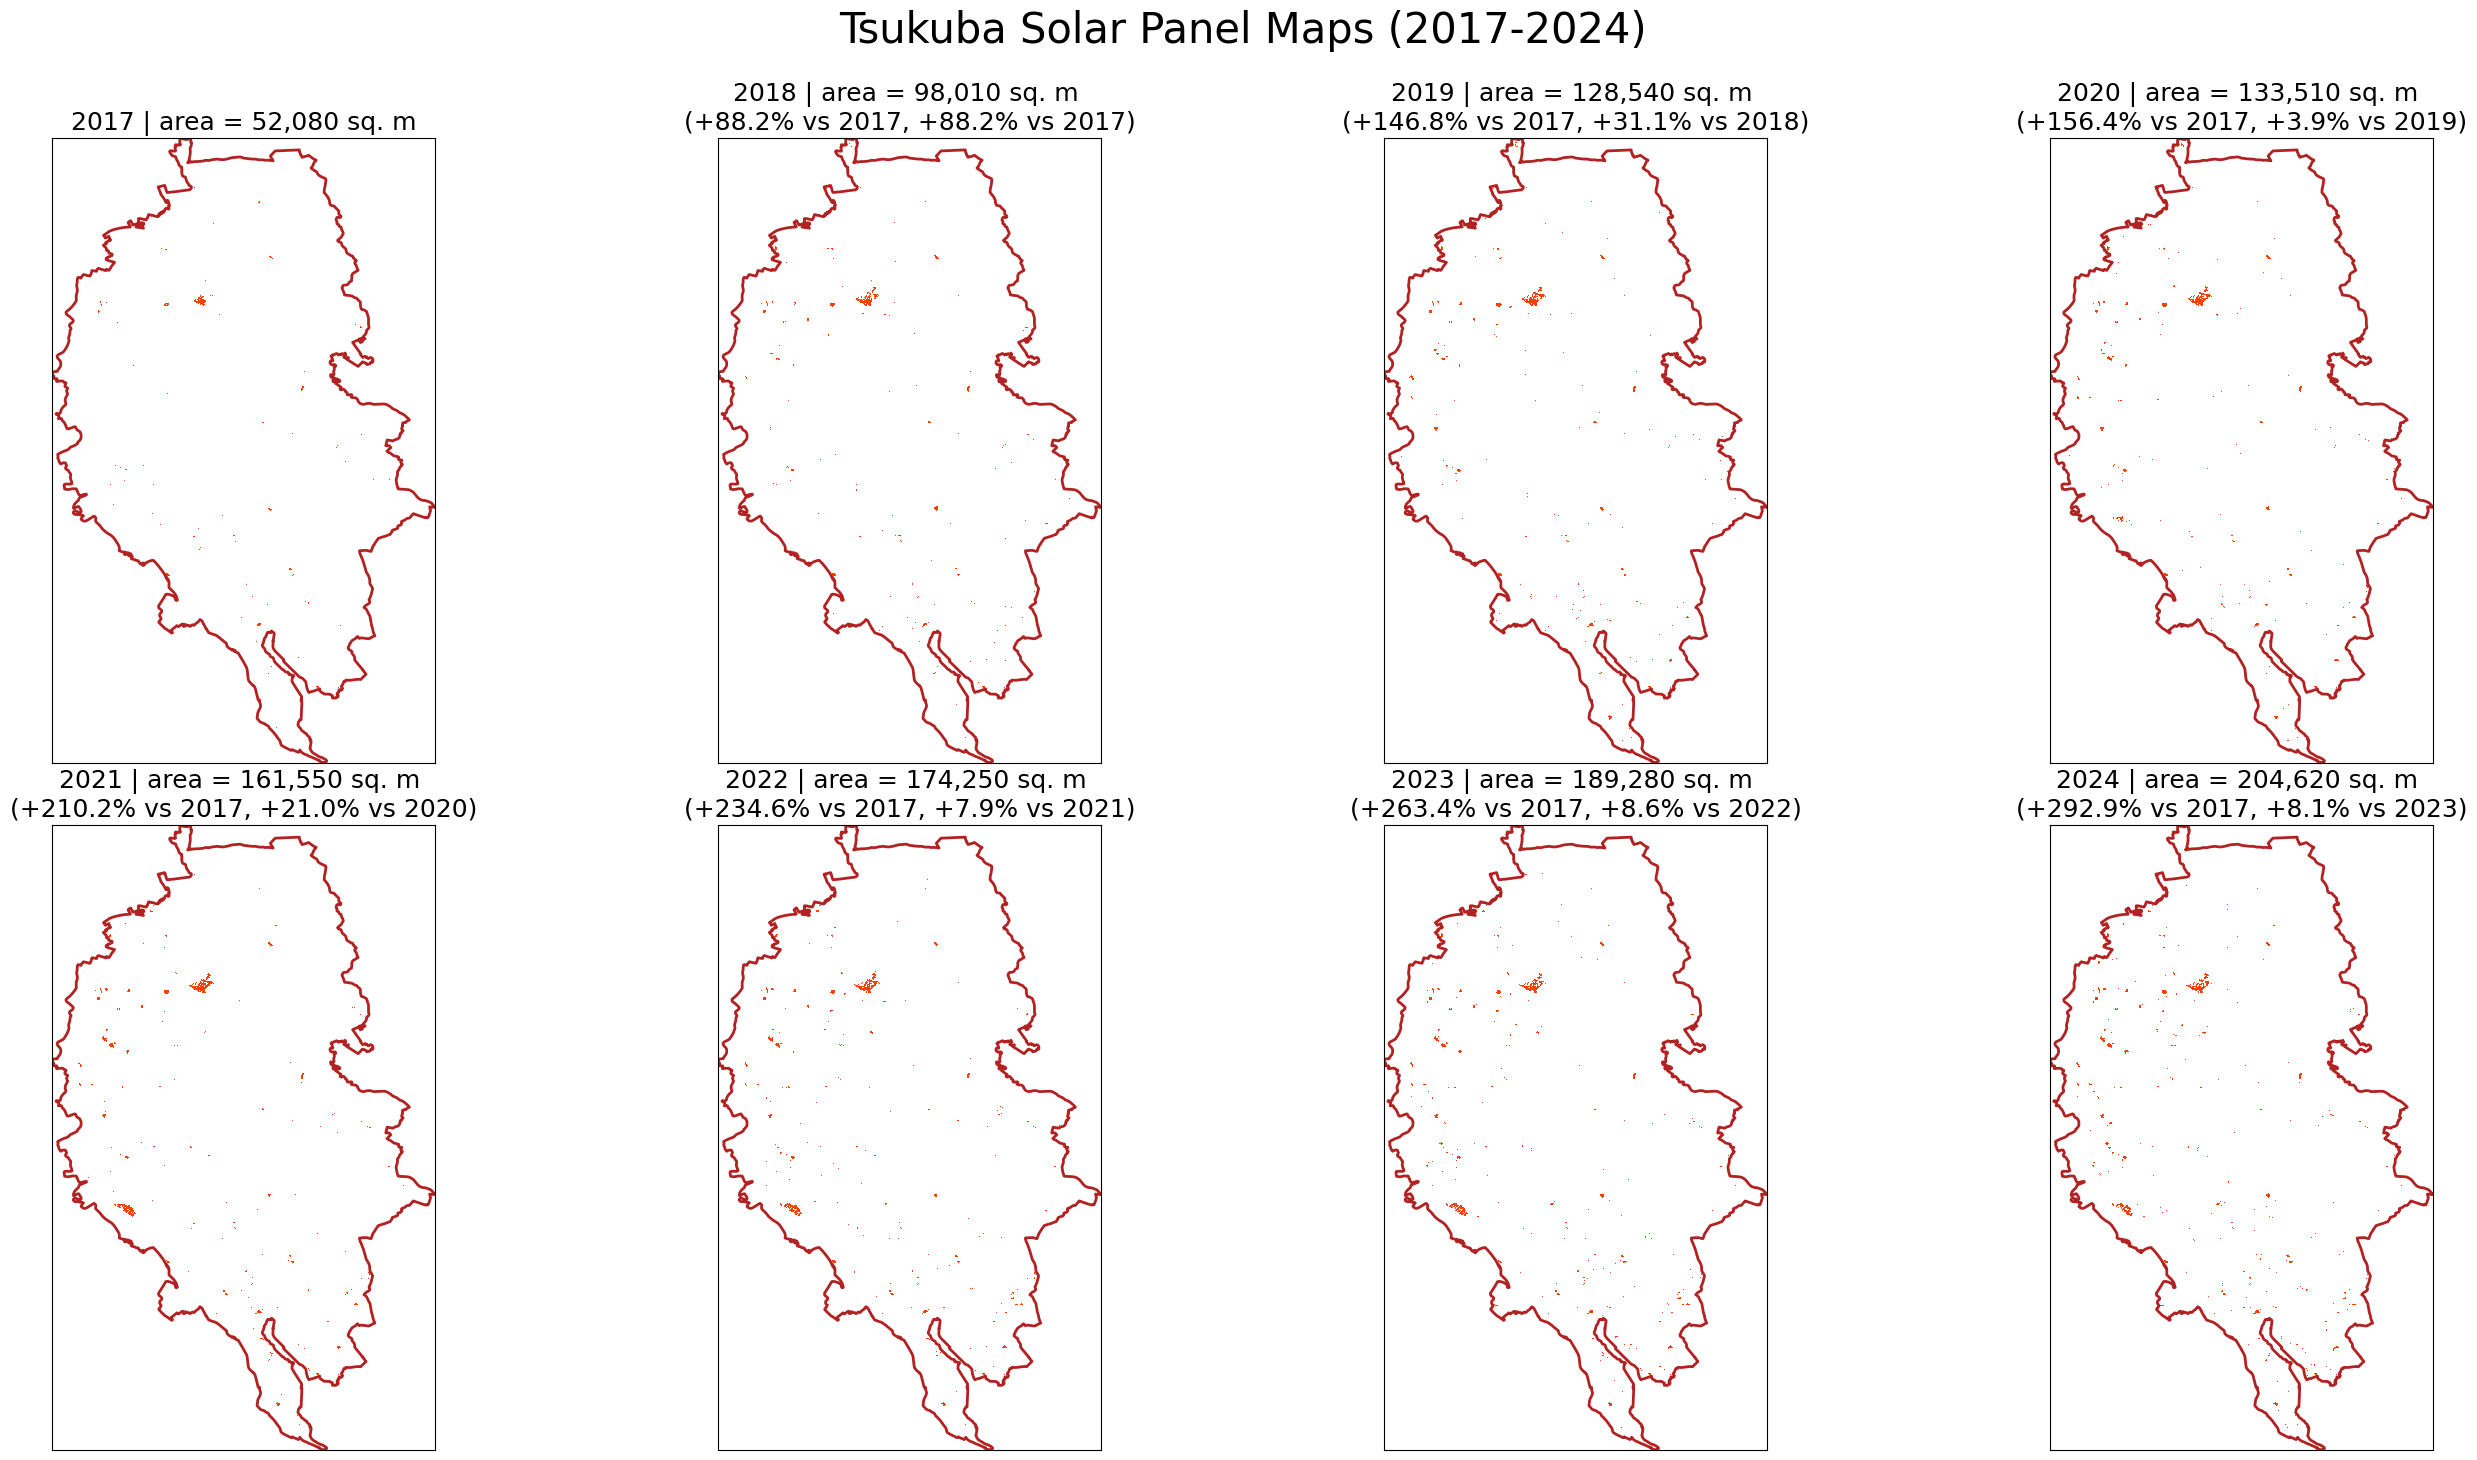

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rasterio
import geopandas as gpd
from pathlib import Path

# Resolve repo root (handles running from notebooks/ or repo root)
candidates = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
repo_root = None
for cand in candidates:
    if (cand / 'map').exists():
        repo_root = cand
        break
if repo_root is None:
    raise FileNotFoundError('Cannot locate repo root with a map/ directory')

raster_paths = [
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2017.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2018.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2019.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2020.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2021.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2022.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2023.tif',
    repo_root / 'map/tsukuba_solarpanel_class_rf_grid_2024.tif',
]
years = [p.stem.split('_')[-1] for p in raster_paths]

# Load city boundary
city_path = repo_root / 'map/tsukuba_gp.gpkg'
city_gdf = gpd.read_file(city_path) if city_path.exists() else None

# Color map: 0 transparent, 1 bright orange
cmap = ListedColormap([[0, 0, 0, 0], [1.0, 0.25, 0.0, 1.0]])

fig, axes = plt.subplots(2, 4, figsize=(28, 16), constrained_layout=False, sharex=True, sharey=True)
fig.subplots_adjust(left=0.03, right=0.97, top=0.9, bottom=0.08, wspace=0.05, hspace=0.1)
fig.suptitle('Tsukuba Solar Panel Maps (2017-2024)', fontsize=30)

areas = {}
baseline_area = None

# Determine common extent from first available raster
ref_extent = None
for p in raster_paths:
    if p.exists():
        with rasterio.open(p) as src:
            b = src.bounds
            ref_extent = [b.left, b.right, b.bottom, b.top]
        break

for ax, path, year in zip(axes.flat, raster_paths, years):
    if not path.exists():
        ax.set_title(f"{year} (missing)", fontsize=16)
        ax.axis('off')
        continue
    with rasterio.open(path) as src:
        data = src.read(1)
        b = src.bounds
        extent = [b.left, b.right, b.bottom, b.top]
        pixels = int((data == 1).sum())
        area_val = pixels * 10  # per request
        areas[year] = area_val
        if baseline_area is None:
            baseline_area = area_val
        ax.imshow(data, cmap=cmap, extent=extent, origin='upper', interpolation='nearest')
        if city_gdf is not None:
            city_gdf.to_crs(src.crs).plot(ax=ax, facecolor='none', edgecolor='firebrick', linewidth=2.0)
        if year == '2017':
            title = f"{year} | area = {area_val:,.0f} sq. m"
        else:
            inc_vs_2017 = ((area_val - baseline_area) / baseline_area * 100) if baseline_area else 0
            prev_year = str(int(year) - 1)
            prev_area = areas.get(prev_year, None)
            if prev_area:
                inc_vs_prev = ((area_val - prev_area) / prev_area * 100)
                title = (
                    f"{year} | area = {area_val:,.0f} sq. m \n"
                    f"(+{inc_vs_2017:.1f}% vs 2017, +{inc_vs_prev:.1f}% vs {prev_year})"
                )
            else:
                title = (
                    f"{year} | area = {area_val:,.0f} sq. m \n"
                    f"(+{inc_vs_2017:.1f}% vs 2017)"
                )
        ax.set_title(title, fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        if ref_extent is not None:
            ax.set_xlim(ref_extent[0], ref_extent[1])
            ax.set_ylim(ref_extent[2], ref_extent[3])

# No north arrow or scale bar
plt.show()
